# Abdennour Kerboua
#### **Made alone**
---

**Emotion Recognition based on facial landmarks**

This part of the practical session is about **emotion recognition** based on facial landmarks. We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) to recognize the emotion of a person by analyzing 68 facial landmarks (already estimated and placed). Below, you will find a picture with an example. We will focus on two emotions neutral and happy.

Please answer all questions and complete the code where you see **XXXXXXXXXXXXX**

**Deadline**: Upload this notebook, the one about Toy Examples and the answers to the theoretical questions to E-Campus. Please verify the exact deadline on E-Campus.

First of all, we need to load the data. In Google Colab, we can load from Google Drive or from our local machine. Since it's faster from Google Drive, let's load them from (my) Google Drive, using the following code.

In [7]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='15vsAdMepHzdoZ3iqNS3kpI3KGW7D0vRs',
  dest_path='./Data_FEI.npz')
  gdd.download_file_from_google_drive(file_id='1ywQbf23-JoPklWCcH_mi5Nuw5BQskxvB',
  dest_path='./facial_landmarks_68markup.jpg')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
# You should write the absolute path of your working directory with the data
Working_directory="data/"    

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


Otherwise, you can also load them from your local machine using the following code

In [ ]:
"""
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
"""      

Let's load the Python packages containing the functions needed for the practical session.

In [36]:
import numpy as np
from time import time

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import paired_distances, pairwise_distances
from sklearn.model_selection import  cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
# this is needed to plot figures within the notebook
%matplotlib inline 
np.random.seed(seed=666)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

from sklearn.pipeline import make_pipeline

We also load a user-defined function useful for plotting the confusion matrix

In [3]:
# Code from scikit-learn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Now, let's load the data. 

We have a list of images, the position of the original landmarks (aligned to the images), the position of the landmarks after a normalization process called Generalized Procrustes Analysis (please refer to https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis), the outputs with the class labels and the names of the images.

Generalized Procrustes Analysis (GPA) is used to keep only shape differences between the configurations of landmarks. That is to say, we align all configurations to an average one using only rigid transformations (uniform scaling, rotation and translation). This means that if I take a facial picture of subject A, then step back, translate and rotate a bit the camera and retake a facial picture of the same subject (who has not moved) the two picture will be different with therefore different landmark position. However, after a GPA, the two landmark configurations should be perfectly aligned removing the "nuisance" differences related to rotation, translation and uniform scaling.

In [8]:
# Parameters
dim=2 # dimension   
# Loading data
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    X = data['Landmarks_FEI'] # original landmarks   
    XGPA = data['Landmarks_FEI_GPA'] # landmarks after GPA (Generalized Procrustes Analysis, https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis)
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']    
N,M = X.shape # number subjects 
M = int(M/2) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M) 
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


Here, we show an example of facial landmarks

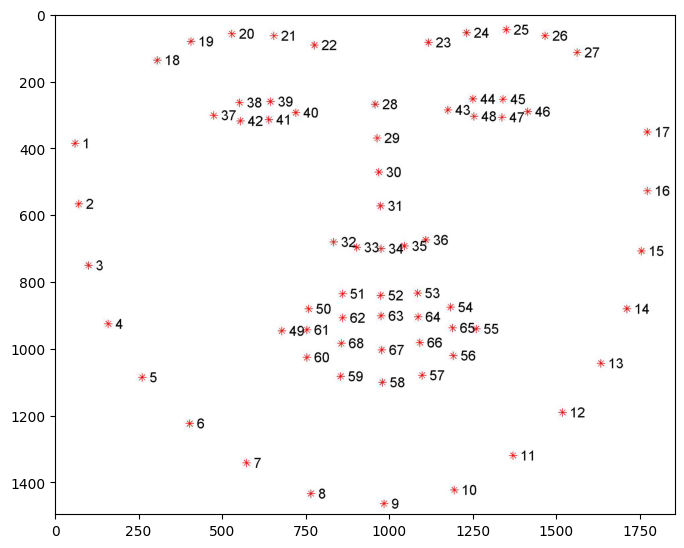

In [9]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (8,8)) # Size of the plot
plt.imshow(Example)
plt.show()

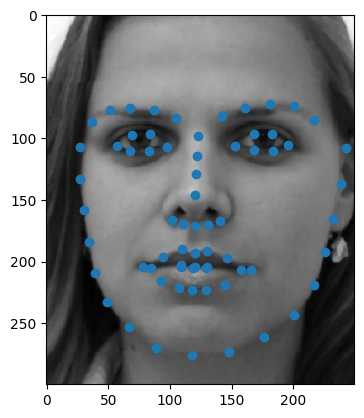

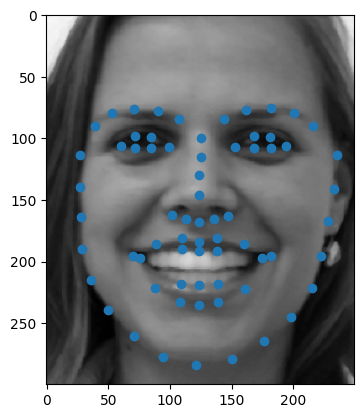

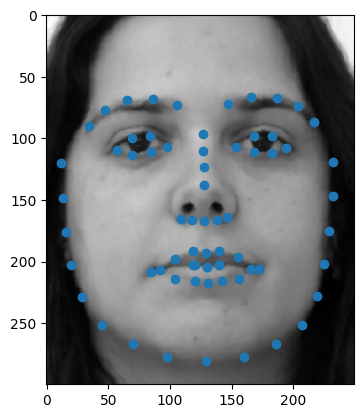

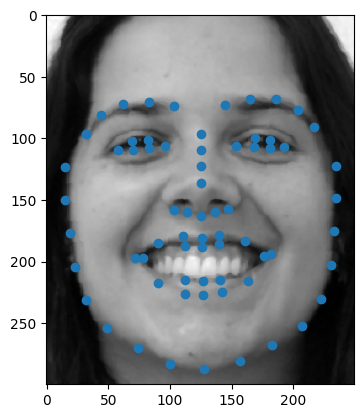

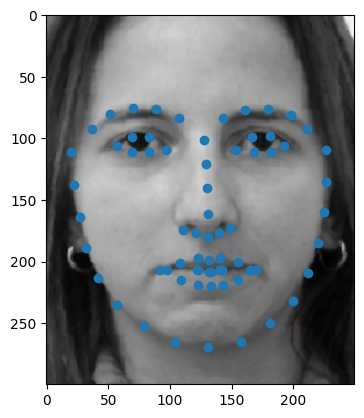

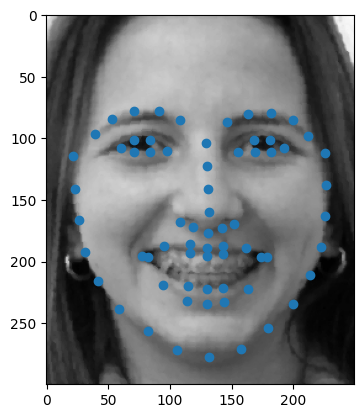

In [10]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Images[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=X[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()



---



**Question**: after plotting the first 6 images of the data-set, what do you notice ? Do you notice a regular pattern ? Do you think that it would be worth it to randomly shuffle the data ?




---



---
**Answer:** The data set seems to be organized that way : neutral face of subject $n-th$ followed bu a happy face of the $n-th$ subject. This organization may undermine the learning since we assume the samples are independant and random. It then may be worth it to randomly shuffle it.

---

In [11]:
# Shuffle data randomly. Hint: Use np.random.shuffle
indeces=np.random.permutation(N)

XpGPA=XGPA[indeces]
Xp=X[indeces]
Yp=Y[indeces]
Imagesp=Images[indeces]
Xmean = np.mean(XpGPA,axis=0) # Compute average

Namesp=[''] * N
for i in range(0,N):
    Namesp[i]=Names[indeces[i]]   



---



Among the loaded data, we also have aligned landmarks after a Generalized Procrustes Analysis. Let's check them and compare them with the landmarks before alignement.


**QUESTION**: Please comment the results. What can you notice ?




---



---
**Answer:** The influence of every factor except the shape is greatly diminished. The landmarks are aligned and so we notice more easily the difference between the two classes ('happy'/'sad').

---

Text(0.5, 1.0, 'Landmarks BEFORE alignement (GPA)')

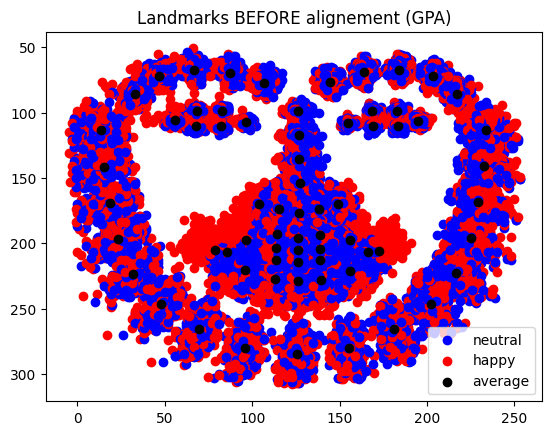

In [12]:
# Plot all landmarks BEFORE GPA
plt.figure()
for i in range(0,N):
    landmark=Xp[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
Xaverage = np.mean(Xp,axis=0) # Compute average
average=plt.scatter(Xaverage[::2],Xaverage[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis() 
plt.title('Landmarks BEFORE alignement (GPA)')

Text(0.5, 1.0, 'Landmarks AFTER alignement (GPA)')

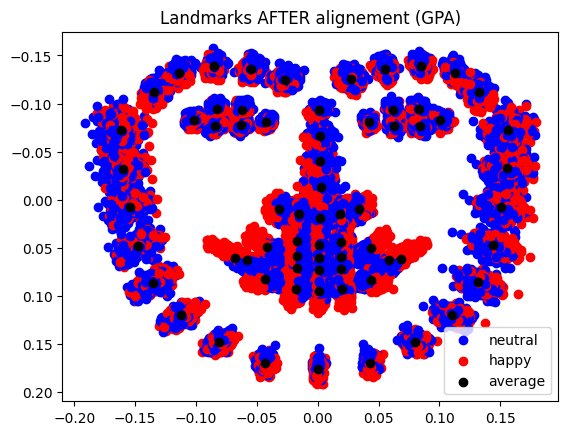

In [13]:
# Plot all landmarks AFTER GPA
plt.figure()
for i in range(0,N):
    landmark=XpGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
average=plt.scatter(Xmean[::2],Xmean[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis()   
plt.title('Landmarks AFTER alignement (GPA)')



---


We need now to compute some features for the classification algorithms. As first idea, we could use the paired Euclidean distances between the landmarks of every subject and the landmarks of the average configuration. 



---



In [20]:
# Compute distances from the average configuration (features)
dist_average=np.zeros((N,M))
average=np.reshape(Xmean,(M,2)) # Reshape average as matrix

for i in range(N):
    landmark= XpGPA[i,:].reshape((M,2))
    # Reshape all landmarks as matrices
    dist_average[i]=np.sqrt(np.sum((landmark-average)**2,axis=1))  

print('Number of subjects N is: ', dist_average.shape[0], ' ; number of features is: ',  dist_average.shape[1] )


Number of subjects N is:  400  ; number of features is:  68


Let's divide the data-set into Training and Test sets:

In [21]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(dist_average, np.ravel(Yp), test_size=0.33, random_state=42)

---

**Question**: One usual question in Machine Learning is, do we need to scale/normalize the features ? What do you think ? Should we do it in this case ? Compute both scaled and normalized data.

Please note that we compute the parameters of 'StandardScaler()' and 'MinMaxScaler()' using only the training set and then we trasform both the traning and test sets using the parameters learnt only on the training set.

**Question**: Why do we do that in your opinion ?

---

---
**Answer**: The scaling and centering of the features are fundamental because learning algorithm used assume that samples have the same variance and are centered. It avoids to have a great feature dominating the learning especially in presence of outliers. In our case, after the execution of GPA alignment, landmarks seem to have similar variances and the distance computed to be centered, so it may not be very useful.

**Answer**: Data variances and averages are considered as model parameters, including scaling and normalization steps. Parameters must be evaluated on the training set and tested on the testing set.

---

In [22]:
# Scale data (each feature will have average equal to 0 and unit variance)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale=scaler.transform(X_train)
X_test_scale=scaler.transform(X_test)

# Normalize data (each feature will be scaled into the range 0,1)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html?highlight=minmaxscaler#sklearn.preprocessing.MinMaxScaler

normalizer = MinMaxScaler()
normalizer.fit(X_train)
X_train_normalize=normalizer.transform(X_train)
X_test_normalize=normalizer.transform(X_test)




---



Let's try to fit LDA to all training sets and predict the error on their respective test sets. 

**Question**: Compare the performnces between original, scaled and normalized data. Comment the results.



---



---
**Answer:** As predicted, the scaling/normalization does not influence the accuracy/precision of the classifier.

---

Fitting LDA to training set
done in 0.008s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 640x480 with 0 Axes>

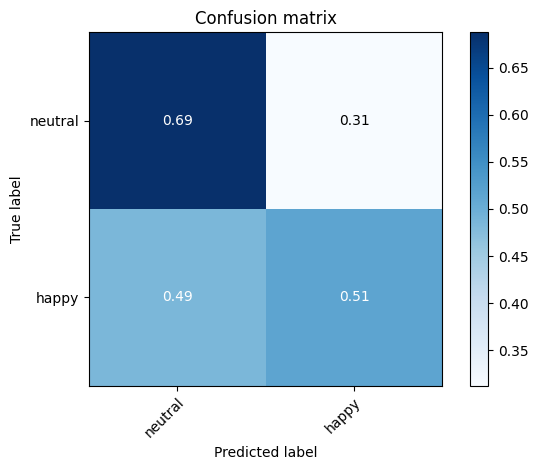

In [23]:
# Fitting LDA to original data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

Fitting LDA to training set
done in 0.007s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 640x480 with 0 Axes>

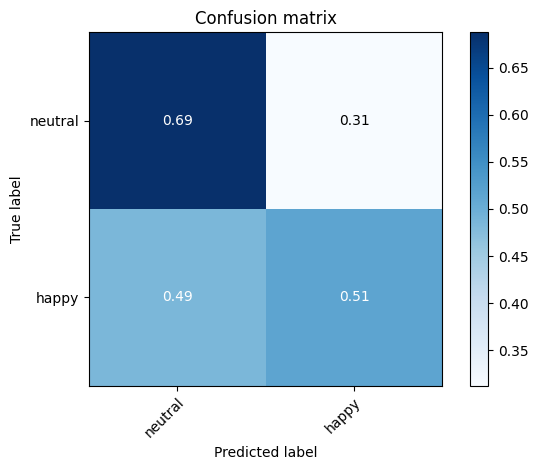

In [26]:
# Fitting LDA to scaled data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train)
y_pred = lda.predict(X_test_scale)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

Fitting LDA to training set
done in 0.008s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 640x480 with 0 Axes>

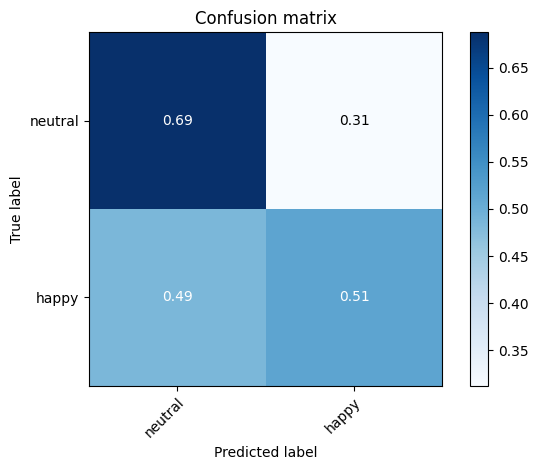

In [27]:
# Fitting LDA to normalized data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_normalize, y_train)
y_pred = lda.predict(X_test_normalize)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()



---

We can then use the function 'cross_val_score' to compute the CV score. Let's use all methods seen today. 

---






In [25]:
# Cross-validation for Model Assessment

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.037s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.088s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logistic Regression
done in 0.179s
 Average and std CV score : 0.5349999999999999 +- 0.0483476990145343
Fitting Naive-Bayes
done in 0.023s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting K-nearest neighbour
done in 0.095s
 Average and std CV score : 0.6049999999999999 +- 0.032210246816812824


---
**Question**: compare the performances between original, scaled and normalized data

Be careful, if you want to standardize your data within a cross validation it means that you should fit 'StandardScaler()' only to the K-1 training folds without using the K-th test fold ! And then transform all folds.
How can we do that ? 

Scikit-learn gives us a very nice tool: THE PIPELINE ! It makes it easier to chain standardization, normalizations, etc. with estimators during a cross validation. Please have a look here: https://scikit-learn.org/stable/common_pitfalls.html

How can we build a Pipeline? It's very simple. Just concatenate the trasformation and the the estimator you want to use:

model = make_pipeline(StandardScaler(), LinearRegression())

---


---
**Answer:** The Standaridzation or Normalization does not improve the CV score except for the KNN for which the score increases slightly.

---

In [30]:
# Cross-validation for Model Assessment with Standaridzation
print("Cross-validation for Model Assessment with Standaridzation\n")
# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
logit_score = cross_val_score(logit,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = make_pipeline(StandardScaler(), GaussianNB())
GNB_score = cross_val_score(GNB,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
neigh_score = cross_val_score(neigh,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Cross-validation for Model Assessment with Standaridzation

Fitting LDA
done in 0.031s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.157s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logistic Regression
done in 0.141s
 Average and std CV score : 0.55 +- 0.01767766952966367
Fitting Naive-Bayes
done in 0.013s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting K-nearest neighbour
done in 0.074s
 Average and std CV score : 0.5625 +- 0.013693063937629145


In [29]:
# Cross-validation for Model Assessment with Normalization
print("Cross-validation for Model Assessment with Normalization\n")
# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline(MinMaxScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline(MinMaxScaler(), QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = make_pipeline(MinMaxScaler(), LogisticRegression(solver='lbfgs'))
logit_score = cross_val_score(logit,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = make_pipeline(MinMaxScaler(), GaussianNB())
GNB_score = cross_val_score(GNB,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=3))
neigh_score = cross_val_score(neigh,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.024s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.061s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logistic Regression
done in 0.062s
 Average and std CV score : 0.57 +- 0.03588175023601831
Fitting Naive-Bayes
done in 0.019s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting K-nearest neighbour
done in 0.129s
 Average and std CV score : 0.5725 +- 0.033911649915626375



---

In the previous example we have fixed the hyper-parameter K to 3. We could use CV to find the best value.

---



The best K is 7  with an average validation score equal to  0.6399999999999999


Text(0, 0.5, 'CV Validation Score')

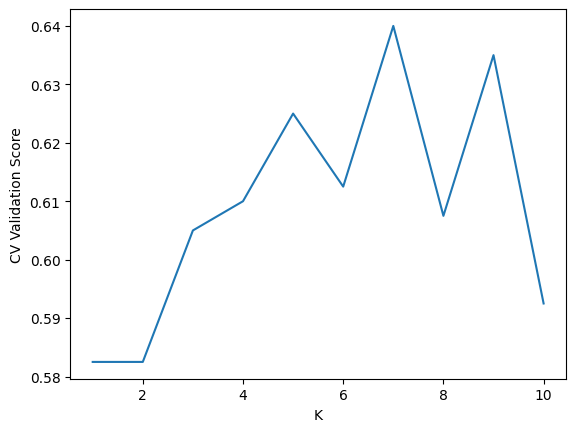

In [31]:
# Looking for the best K in K-nearest neighbour
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(dist_average, np.ravel(Yp))

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')



---



We could also use CV to assess the prediction error (generalization error) in a left-out test set.



---



The best K is 5  with an average validation score equal to  0.6044025157232704
The test score is 0.6590909090909091


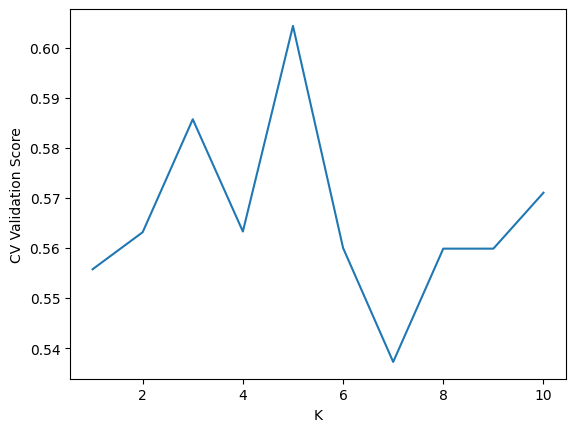

In [32]:
# We only use the training set for finding the best hyper-parameter
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test, y_test))



---



**Question**: Comment the results of the two previosu experiments. What about the best K and validation/test error ? Are the results the same ? Why in your opinion ?



---



---
**Answer:** The results are not the same. The best $k$ training only on the train set is lower because the set is smaller. It then allows to make up for the diminution of the dataset size. A lower $k$ means lower complexity that is necessary with a smaller dataset to avoid overfitting, but higher bias (lower validation score) according to **bias/variance tradeoff**.

---



---



It seems that these features do not work very well... let's try to change them.
We can use the distances between all combinations of landmarks. Each subject has M*(M-1)/2 features.



---



In [53]:
from scipy.spatial.distance import pdist

In [54]:
# Use distances between all combinations of landmarks. Each subject has M*(M-1)/2 features
dist_combination=np.zeros((N,int((M*(M-1)/2))))

for i in range(N):
    landmark= XpGPA[i].reshape((M,2))
    # Reshape all landmarks as matrices
    dist_combination[i]=pdist(landmark, metric='euclidean').reshape((1,int(M*(M-1)/2)))


print('Number of subjects N is: ', dist_combination.shape[0], ' ; number of features is: ',  dist_combination.shape[1] )


Number of subjects N is:  400  ; number of features is:  2278


In [55]:
X2_train, X2_test, y2_train, y2_test = train_test_split(dist_combination, np.ravel(Yp), test_size=0.33, random_state=42)

In [74]:
scaler = StandardScaler()
scaler.fit(X2_train)
X2_train_scale=scaler.transform(X2_train)
X2_test_scale=scaler.transform(X2_test)

**Question**: Should we scale/normalize the new features ?

**Answer:** The presence of outliers is more likely in this situation so the scaling/centering step may be more useful here.

Use the classification algorithms seen before to test the discriminative power of the new features. 

#### Raw Data

In [64]:
# Cross-validation for Model Assessment

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.542s
 Average and std CV score : 0.9174999999999999 +- 0.023184046238739257
Fitting QDA


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 1.958s
 Average and std CV score : 0.6200000000000001 +- 0.065
Fitting Logistic Regression
done in 0.183s
 Average and std CV score : 0.9475 +- 0.019999999999999976
Fitting Naive-Bayes
done in 0.028s
 Average and std CV score : 0.9475 +- 0.031024184114977156
Fitting K-nearest neighbour
done in 0.083s
 Average and std CV score : 0.9425000000000001 +- 0.024494897427831803


### Standardization

In [63]:
# Cross-validation for Model Assessment with Standardization

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
logit_score = cross_val_score(logit,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = make_pipeline(StandardScaler(), GaussianNB())
GNB_score = cross_val_score(GNB,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=3))
neigh_score = cross_val_score(neigh,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.632s
 Average and std CV score : 0.9174999999999999 +- 0.023184046238739257
Fitting QDA


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 2.424s
 Average and std CV score : 0.6275000000000001 +- 0.03391164991562636
Fitting Logistic Regression
done in 0.739s
 Average and std CV score : 0.96 +- 0.02549509756796394
Fitting Naive-Bayes
done in 0.096s
 Average and std CV score : 0.9475 +- 0.031024184114977156
Fitting K-nearest neighbour
done in 0.116s
 Average and std CV score : 0.9225 +- 0.03657184709581952


In [65]:
# Cross-validation for Model Assessment with Normalization

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline(MinMaxScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline(MinMaxScaler(), QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = make_pipeline(MinMaxScaler(), LogisticRegression(solver='lbfgs'))
logit_score = cross_val_score(logit,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = make_pipeline(MinMaxScaler(), GaussianNB())
GNB_score = cross_val_score(GNB,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = make_pipeline(MinMaxScaler(),KNeighborsClassifier(n_neighbors=3))
neigh_score = cross_val_score(neigh,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.782s
 Average and std CV score : 0.9174999999999999 +- 0.023184046238739257
Fitting QDA


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 1.814s
 Average and std CV score : 0.585 +- 0.05086747487343952
Fitting Logistic Regression
done in 0.339s
 Average and std CV score : 0.975 +- 0.032596012026013255
Fitting Naive-Bayes
done in 0.083s
 Average and std CV score : 0.9475 +- 0.031024184114977156
Fitting K-nearest neighbour
done in 0.077s
 Average and std CV score : 0.93 +- 0.032210246816812824




---



mmmm it seems that some variables are collinear. Collinearity means that one variable can be linearly predicted by the others, basically it means that there is redundancy. 

**Question**: Which technique could you use to reduce the collinearity/redundancy ? Use it and test the predictive power of the new features.




---



---
**Answer:** We could definitely use a technique of dimension reduction like PCA, kPCA, ICA or NMF seen in precedent lectures.

---

In [76]:
pca = decomposition.PCA(n_components=0.95)
pca.fit(X2_train_scale)
X_train_pca = pca.transform(X2_train_scale)
X_test_pca = pca.transform(X2_test_scale)

print('Number of samples:', X_train_pca.shape[0], ' ; number of features:', X_train_pca.shape[1])
print('Number of samples:', X_test_pca.shape[0], ' ; number of features:', X_test_pca.shape[1])

Number of samples: 268  ; number of features: 16
Number of samples: 132  ; number of features: 16


### W/o pca

              precision    recall  f1-score   support

           0       0.88      0.95      0.92        64
           1       0.95      0.88      0.92        68

    accuracy                           0.92       132
   macro avg       0.92      0.92      0.92       132
weighted avg       0.92      0.92      0.92       132

Normalized confusion matrix
[[0.953125   0.046875  ]
 [0.11764706 0.88235294]]


<Figure size 640x480 with 0 Axes>

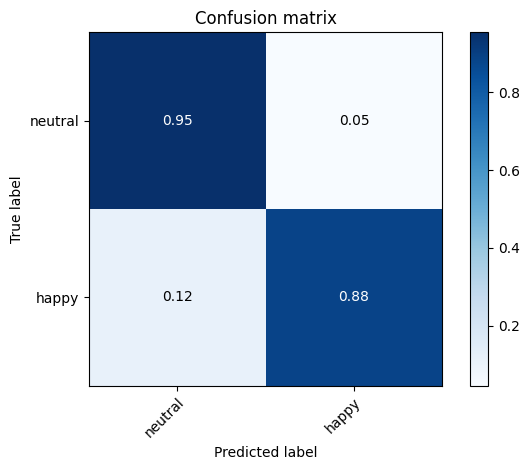

In [77]:
lda = LinearDiscriminantAnalysis()
lda.fit(X2_train_scale, y_train)
y_pred = lda.predict(X2_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

### W/ PCA

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        64
           1       1.00      0.93      0.96        68

    accuracy                           0.96       132
   macro avg       0.96      0.96      0.96       132
weighted avg       0.96      0.96      0.96       132

Normalized confusion matrix
[[1.         0.        ]
 [0.07352941 0.92647059]]


<Figure size 640x480 with 0 Axes>

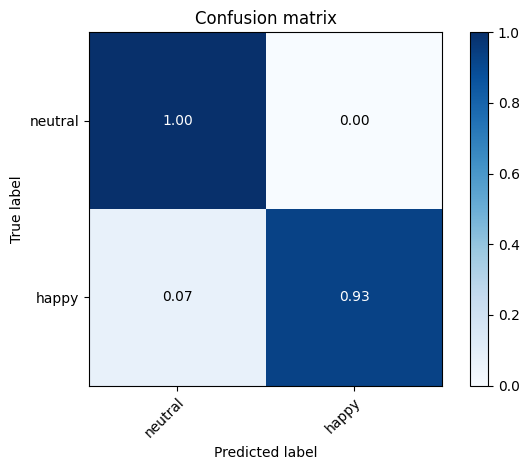

In [78]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_pca, y_train)
y_pred = lda.predict(X_test_pca)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()



---


A second solution, would be to manually select few landmarks



---



In [79]:
# Select lateral landmarks mouth
select_land=[49,50,60,55,54,56]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
  
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  

Number of subjects N is:  400  ; number of features is:  12


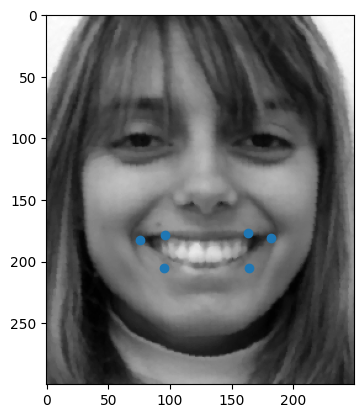

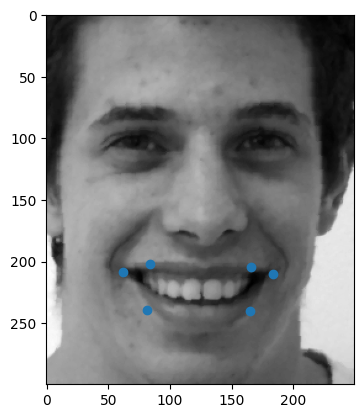

In [80]:
# plot two test images 
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

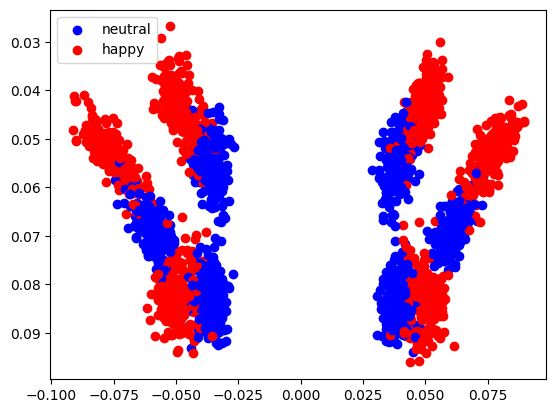

In [81]:
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

In [82]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

Fitting LDA
 Average and std train score : 0.95625 +- 0.006846531968814562
 Average and std test score : 0.9400000000000001 +- 0.021505813167606556


---

Let's plot some images where the best model was wrong. 

---

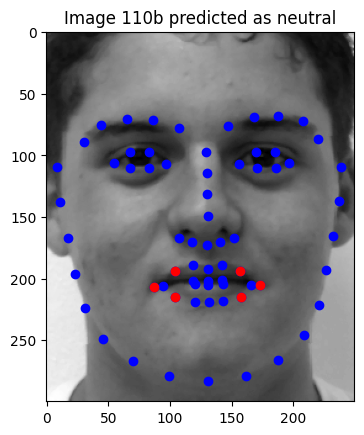

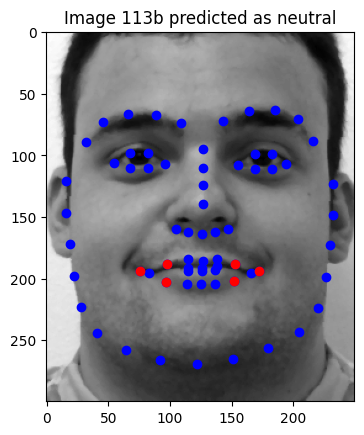

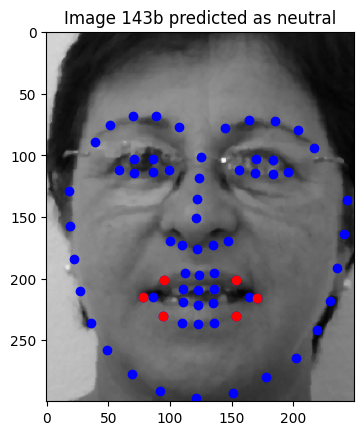

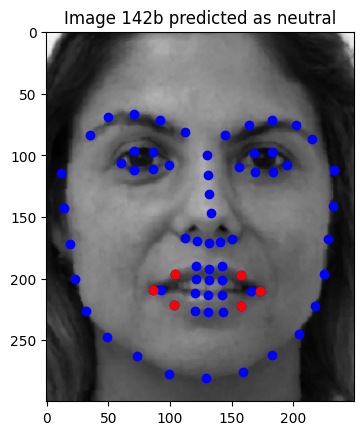

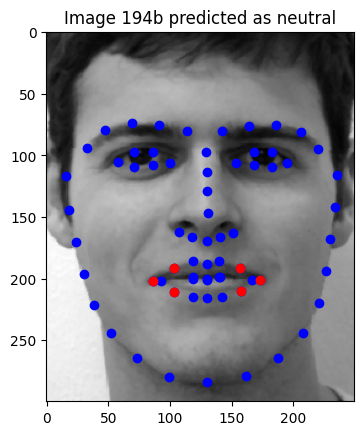

In [83]:
# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob')
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()
 

**Question**: Comment the results. Why did the algorithm make a mistake ? Would you choose other landmarks ? Try at least another combination of landmarks


**Answer:** In those images, the landmarks of the mouth edges are note enough because the smiles on the happy faces are not opened wide enough.

Number of subjects N is:  400  ; number of features is:  30


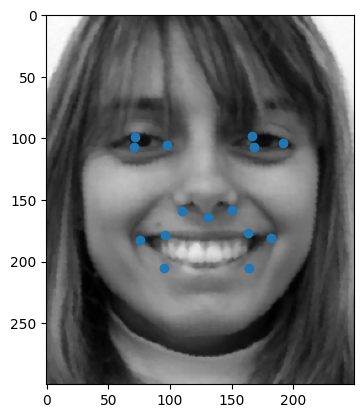

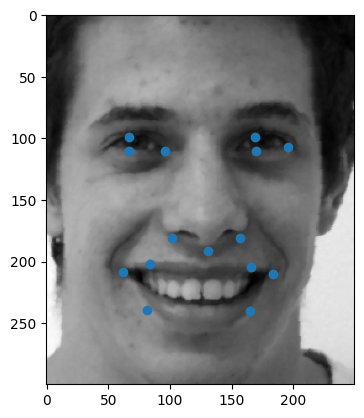

Fitting LDA
 Average and std train score : 0.9731249999999999 +- 0.003750000000000001
 Average and std test score : 0.9575000000000001 +- 0.021794494717703346


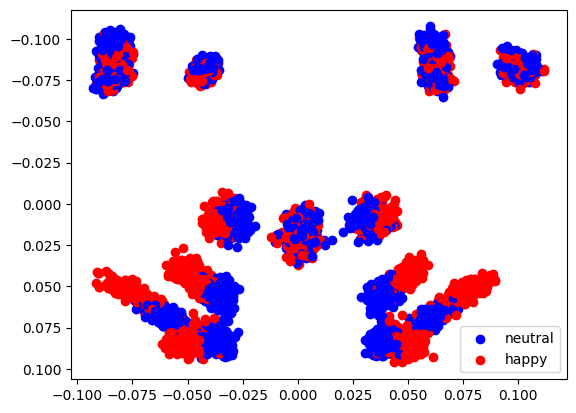

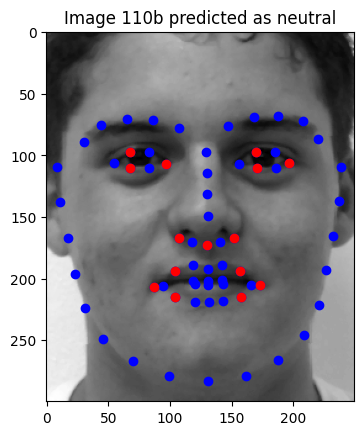

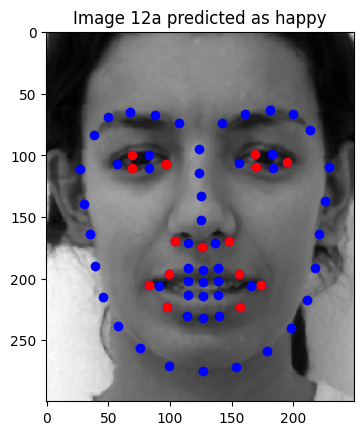

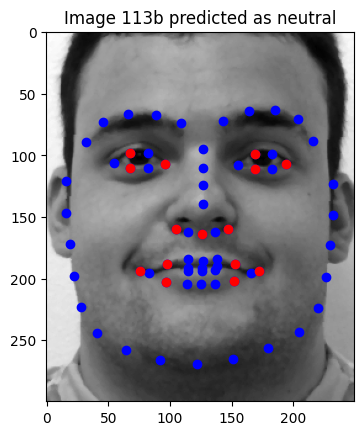

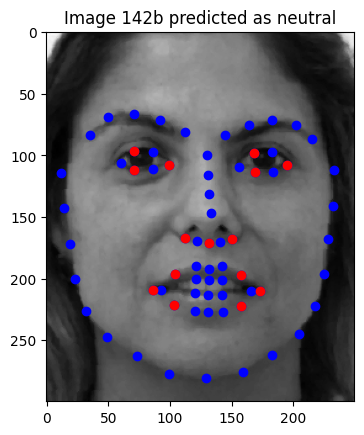

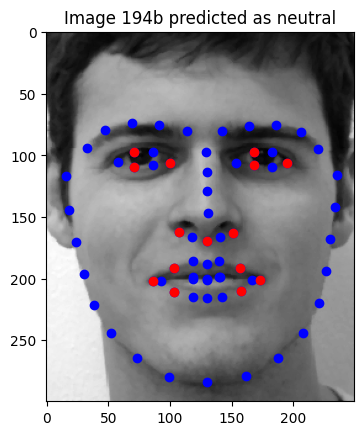

In [84]:
# Select other set of landmarks
select_land=[49,50,60,55,54,56, 32,34,36,38,40,42,44,46,48]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
  
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  


# plot two test images 
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()
    
    
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)
    
# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob')
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()





---


Here, we use Nested Cross-Validation for finding the generalization error and the best K value



---



In [85]:
# Fitting K-nearest neighbour with Nested Cross-Validation
 
print("Fitting K-nearest neighbour with Nested CV")
t0 = time()
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666) # we fix the random state to always have the same results if we relaunch the code
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=neigh, param_grid=parameters, cv=inner_cv)
nested_CV = cross_validate(estimator=clf, X=XpsGPA, y=np.ravel(Yps), cv=outer_cv,return_train_score=True, return_estimator=True, n_jobs=-1)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv train score : {0} +- {1}".format(nested_CV['train_score'].mean(), nested_CV['train_score'].std() ))
print("Average and std Nested Cv test score : {0} +- {1}".format(nested_CV['test_score'].mean(), nested_CV['test_score'].std() ))

Fitting K-nearest neighbour with Nested CV


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


done in 0.758s
Average and std Nested Cv train score : 0.9650000000000001 +- 0.007234898064243887
Average and std Nested Cv test score : 0.9550000000000001 +- 0.020310096011589906


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


---

**Question**: Are Training and Test scores similar ? What does it mean ?

---

---
**Answer:**  The train and test scores are very similar which means the model is nor overfitted nor underfitted. The model generalizes well the training data relations.

---

**Question (OPTIONAL)**: Please propose at least another set of features using landmarks and/or pixel intensities of the images and test its discriminative power